# Basline Univariate Model: Autoregressive Model (AR)

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AutoRegResults
from statsmodels.tsa.ar_model import ar_select_order
import yfinance as yf
from statsmodels.stats.stattools import jarque_bera
import copy
import matplotlib.patches as mpatches
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats

Read stock data

In [38]:
df_prices = pd.read_csv("data/stock_data_daily_pct_change.csv")
df_prices.index = pd.DatetimeIndex(df_prices["Date"]).to_period("D")
df_prices = df_prices.drop('Date', axis = 1)
df_prices = df_prices.drop("Date.1", axis = 1)

# Drop columns with little amount of data (determined in "Sentiment Analysis.ipynb")
df_prices = df_prices.drop(["LLY", "NVDA", "MA", "UNH", "V"], axis = 1)
df_prices

,AAPL,MSFT,BAC,AMZN,TSLA,XOM,JPM,KO,WMT,CVX,JNJ,HD,PG,MRK,PFE
Date,,,,,,,,,,,,,,,
2011-01-04,0.005219,0.003931,0.003524,0.004288,0.001878,0.004695,0.014473,-0.020699,0.003849,-0.003698,0.008437,-0.018125,0.002779,0.008602,0.017534
2011-01-05,0.008180,-0.003204,0.018258,0.013026,0.005999,-0.002670,0.012229,-0.005950,-0.006573,-0.001747,-0.000631,-0.003172,-0.002310,0.005777,0.006671
2011-01-06,-0.000808,0.029286,-0.004138,-0.008324,0.039135,0.006426,-0.004922,-0.007245,-0.008270,-0.008202,-0.001580,-0.004051,-0.001698,0.013676,0.003865
2011-01-07,0.007161,-0.007634,-0.013158,-0.001991,0.012912,0.005453,-0.018885,-0.001745,0.002224,0.005514,-0.009650,-0.001162,-0.002937,0.007825,0.008801
2011-01-10,0.018833,-0.013287,0.010526,-0.004367,0.007436,-0.006086,-0.005500,0.002225,-0.006472,-0.008554,-0.007029,0.000291,-0.002171,-0.004016,-0.004362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.016319,0.000000,0.006007,0.003638,0.033605,0.005004,-0.000292,-0.001092,-0.010475,0.005431,0.002602,-0.008952,-0.003670,0.001747,0.002294
2019-12-24,0.000951,-0.000191,0.001422,-0.002114,0.014384,-0.003842,0.002770,-0.003642,0.004033,0.000083,-0.003483,0.006660,0.002562,-0.003270,-0.000763
2019-12-26,0.019840,0.008197,0.008518,0.044467,0.013380,0.001571,0.010612,0.005666,0.000084,0.002160,-0.000685,0.000680,0.000000,-0.001093,0.002291


### Rationale behind fitting an AR model 

The idea of this AR model is to serve as a baseline to compare the prediction of the VAR model. If the prediction accuracy (i.e. $RMSE$) does not improve when introducing the articles' sentiment data, then $H_2$ (i.e. using sentiment data improves predictions of future Stock value) does not hold. 

The number of lags (i.e. $p$) will be equal to the ones used in the VAR model for the analyzed stock. Thus, each AR model will be equivalent to its corresponding VAR model in every sense except for the addition of the articles' sentiment data. 

**Testing assumptions:**

1. Stationarity: 
2. RES avg = 0
3. RES autocor = 0
4. Noramality or residuals

Assumption 1. has already been tested for the VAR fitting. Assumptions 2. 3. and 4. are tested per time-series window after the AR models. 

**Fitting an AR model per time-series window per company**

Here we first slice each companie's time-series into $n$ windows and then fit an $AR$ model to each window. Two dictionaries with companies' ticker names as keys are created. First, `comp_mod` stores all the fitted models for a given company. Secondly, `comp_ass` stores for each company a data set with diagnostics for assumption 2., 3. and 4. for each window. 

In [39]:
# DEFINING FUNCTION TO SLICE TIME-SERIES INTO WINDOWS OF CERTAIN SIZE
def sliding_windows(df, window_size) -> list:
    # Create sliding windows of timeseries for each variable in the dataframe
    # create sliding windows of timeseries per stock:
    list_of_windows_per_variable = []
    for variable in df.columns:
        variable_timeseries = df[str(variable)]
        # Define the window size

        # Initialize the list of windows
        windows = []

        # Iterate over the time series
        for i in np.arange(len(variable_timeseries.index) - window_size + 1, step = window_size):
            # Take the last `window_size` elements of the time series
            # windows are non overlapping, i.e. the first window is from index 0-20, the next from 20-40 etc. 
            # instead of first window being index 0-20, second window being 1-21, etc.
            current_window = variable_timeseries[i : i+window_size]
            window_index = variable_timeseries.index[i : i+window_size]
            # Add the current window to the list of windows
            windows.append(pd.DataFrame(current_window, index = window_index))
        list_of_windows_per_variable.append(windows)
    return list_of_windows_per_variable

In [40]:
# NUMBER OF LAGS USED FOR EACH COMPANY 
lags = [13,16,6,9,4,5,4,8,5,10,7,5,8,6,16]

# CREATING WINDOWS FOR EACH COMPANY (WITH WINDOW SIZE 78 WE OBTAIN 29 WINDOWS)
windows = sliding_windows(df_prices,78)

# DICTIONARY CONTAINING MODELS PER COMPANY 
comp_mod = {'AAPL': [], 'MSFT': [], 'BAC': [], 'AMZN': [], 'TSLA': [], 'XOM': [], 'JPM': [], 'KO': [], 'WMT': [], 'CVX': [],
       'JNJ': [], 'HD': [], 'PG': [], 'MRK': [], 'PFE': []}

# DICTIONARY CONTAINING MODEL'S ASSUMPTIONS DIAGNOSTIC PER COMPANY
comp_ass = {'AAPL': [], 'MSFT': [], 'BAC': [], 'AMZN': [], 'TSLA': [], 'XOM': [], 'JPM': [], 'KO': [], 'WMT': [], 'CVX': [],
            'JNJ': [], 'HD': [], 'PG': [], 'MRK': [], 'PFE': []}
    
for i, comp in enumerate(windows):

    # FOR MODEL 
    name = comp[0].columns[0]
    p = lags[i]
    models = []

    # FOR ASSUMPTIONS 
    res_av = []
    res_cor = []
    norm_test = []
    res_var = []
    
    for window in comp: 
        ar_model = AutoReg(window, lags=p).fit()

        models.append(ar_model)

        # ASSUMPTION: 
        res_av.append(np.mean(ar_model.resid))
        res_cor.append(durbin_watson(ar_model.resid))
        norm_test.append('norm' if jarque_bera(ar_model.resid)[1]>=0.05 else 'not_norm')
        # HOMOSCHEDASTICITY 
        g1,g2,g3,g4,g5 = np.array_split(ar_model.resid,5)
        res_var.append('equal' if stats.levene(g1,g2,g3,g4,g5)[1]>= 0.05 else 'not equal')    
    
    df = pd.DataFrame({'window': [f'W{i}' for i in range(len(comp))],'res_av': res_av,'res_cor_dw_statistic':res_cor,'res_norm':norm_test,'res_var':res_var})
    comp_ass[name] = df

    comp_mod[name] = models

c:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


**Forecasting**

At this stage we want to do the same forecast performed with the VAR model, which involves the period from 2019/12/30 to 2020/1/20. For each company we obtain the actual stock values for this period from Yahoo Finance (this means **14 data points given** there are 14 working days). We use each of the trained models (i.e. one per window) to generate a 14 steps forecast. The actual stock values, the individual model forecast and the averaged forecast value are plotted for each company. Usin the prediction error, the average RMSE of the models and the $95\%~CI$ is computed per company.  

Manual prediction function: 

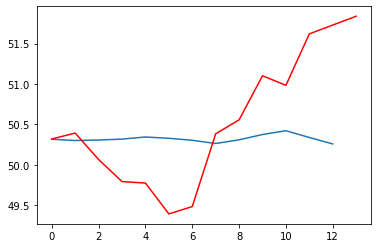

In [63]:
name = 'KO'

model = comp_mod[name][len(comp_mod[name])-1]
initial_values = df_prices[name][-model.ar_lags[-1:][0]:]
test_prices = pd.DataFrame(yf.Ticker(name).history(start = '2019-12-30', end = '2020-1-20')['Close'])['Close']
test_prices


def predictions(model,initial_values,test_prices):
    
    model_lags = model.ar_lags[-1:][0]
    model_coefs = model.params

    predictions_raw = []
    for i in range(len(test_prices)):
        Xt = copy.deepcopy(predictions_raw)

        u = -1
        while len(Xt) < model_lags:
            Xt.append(initial_values[u]) 
            u -= 1
        
        pred = model_coefs[0] = sum([model_coefs[i]*Xt[i] for i in range(model_lags)])
        predictions_raw.insert(0,pred)
    
    predictions_clean = []
    
    for i in range(len(predictions_raw)-1):
        if i == 0:
            predictions_clean.append(test_prices[i] + predictions_raw[i+1]*test_prices[i])
        else: 
            predictions_clean.append(predictions_clean[len(predictions_clean)-1] + predictions_raw[i+1]*predictions_clean[len(predictions_clean)-1])

    return predictions_clean

preds = predictions(model,initial_values,test_prices)


plt.plot(range(len(preds)),preds)
plt.plot(range(len(test_prices)),test_prices,'r-')
plt.show()


In [64]:
def preds_and_rmse(company_name, models_list, plot = True):
    
    # I TAKE THE FIRST ONE OFF BECAUSE 30-12-2019 IS IN TRAINING SET ALREADY
    test_prices = pd.DataFrame(yf.Ticker(company_name).history(start = '2019-12-30', end = '2020-1-20')['Close'])['Close']
    preds_list = []
    RMSE_list = []

    for model in models_list: 

        # predictions_raw = model.forecast(len(test_prices))
        # predictions_clean = []
        # for i in range(len(predictions_raw)-1):
        #     if i == 0:
        #         predictions_clean.append(test_prices[i] + predictions_raw[i+1]*test_prices[i])
        #     else: 
        #         predictions_clean.append(predictions_clean[len(predictions_clean)-1] + predictions_raw[i+1]*predictions_clean[len(predictions_clean)-1])

        initial_values = df_prices[company_name][-model.ar_lags[-1:][0]:]
        predictions_clean = predictions(model,initial_values,test_prices)
        
        sqr_resid = [(test_prices[i]-predictions_clean[i])**2 for i in range(len(predictions_clean))]
        RMSE = (np.mean(sqr_resid))**0.5
        

        preds_list.append(predictions_clean)
        RMSE_list.append(RMSE)
    

    avg_RMSE = np.mean(RMSE_list)
    ci_low = np.percentile(RMSE_list,2.5)
    ci_high = np.percentile(RMSE_list,97.5)

    avg_pred = []
    for i in range(len(preds_list[0])):
        one_time = []
        for p in preds_list:
            one_time.append(p[i])
        avg_pred.append(np.mean(one_time))

    if plot == True:
        return avg_RMSE,ci_low, ci_high, preds_list, avg_pred, test_prices
    else:
        return avg_RMSE,ci_low, ci_high

# preds_and_rmse('AAPL',comp_mod['AAPL'],plot = False)

Graph with individual model predictions, average prediction and actual stock values per company. 

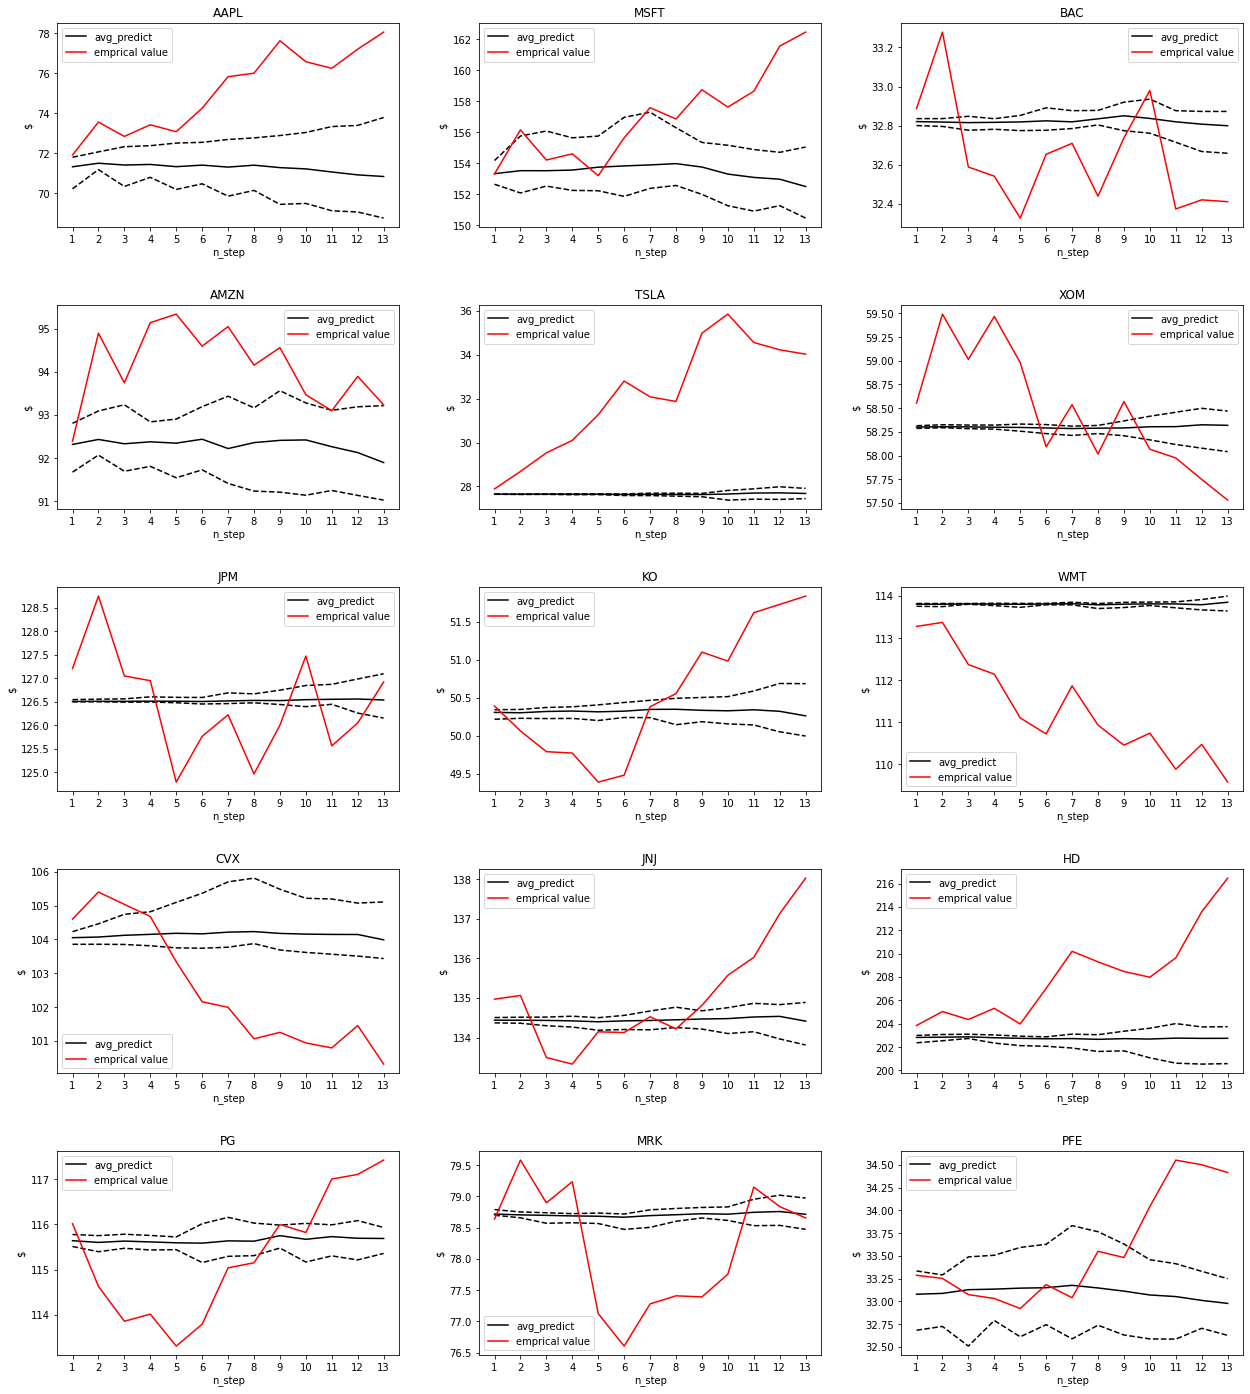

In [76]:
fig = plt.figure(figsize = (18, 20))
for i,name in enumerate(comp_mod,start = 1):

    avg_RMSE, ci_low, ci_high, preds_list,avg_pred,test_prices = preds_and_rmse(name,comp_mod[name])

    plt.subplot(5,3,i)

    # for i,p in enumerate(preds_list):
    #     if i == 0:
    #         plt.plot(range(len(p)),p,color = 'blue',alpha = 0.4,label = 'single_preds')
    #     else:
    #         plt.plot(range(len(p)),p,color = 'blue',alpha = 0.4)
    
    ci_low = []
    ci_high = []

    for s in range(len(preds_list[1])):
        step = []
        for list in preds_list:
            step.append(list[s])
        ci_low.append(np.percentile(step,2.5))
        ci_high.append(np.percentile(step,97.5))

    plt.plot(range(len(avg_pred)),ci_low,color = 'black',linestyle = 'dashed') 
    plt.plot(range(len(avg_pred)),ci_high,color = 'black',linestyle = 'dashed') 
    plt.plot(range(len(avg_pred)),avg_pred,color = 'black',label = 'avg_predict')
    plt.plot(range(len(test_prices[1::])),test_prices[1::],color = 'red',label = 'emprical value')
    plt.title(f'{name}')
    plt.xlabel('n_step')
    plt.xticks(range(0,13), labels = range(1,14))
    plt.ylabel('$')
    plt.legend()

fig.tight_layout(pad = 3)
plt.show()



Graph with RMSE and its CI per company 

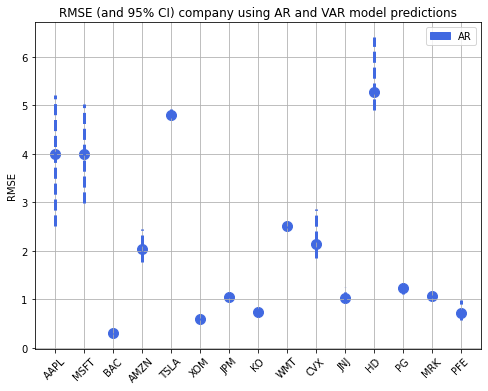

In [83]:
# AR
avg_RMSE = []
low_RMSE = []
high_RMSE = []

for name in comp_mod.keys():
    avg, low, high = preds_and_rmse(name,comp_mod[name],plot = False)
    avg_RMSE.append(avg)
    low_RMSE.append(low)
    high_RMSE.append(high)

# PLOT
fig = plt.figure(figsize = (8,6))
for i,name in enumerate(comp_mod.keys()):
    plt.scatter(i,avg_RMSE[i],color = 'royalblue',s = 100)
    plt.plot(np.repeat(i,2),[low_RMSE[i],high_RMSE[i]],linestyle = 'dashed',linewidth = 3,color = 'royalblue')
plt.xticks(range(len(comp_mod.keys())),labels = list(comp_mod.keys()))

patch1 = mpatches.Patch(color = 'royalblue',label = 'AR')
handles = [patch1]
plt.legend(handles = handles)
plt.xticks(rotation = 45)
plt.ylabel('RMSE')
plt.title('RMSE (and 95% CI) company using AR and VAR model predictions')
plt.grid()
plt.show()



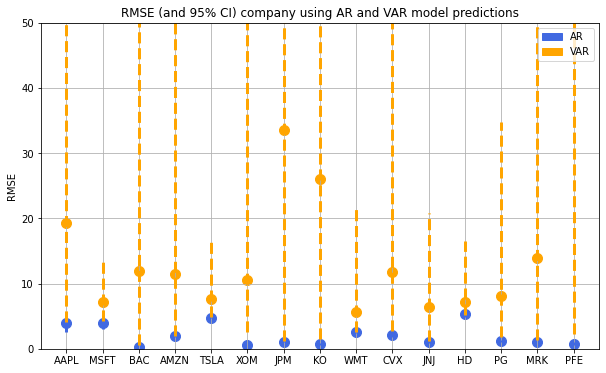

In [87]:
# AR
avg_RMSE = []
low_RMSE = []
high_RMSE = []

for name in comp_mod.keys():
    avg, low, high = preds_and_rmse(name,comp_mod[name],plot = False)
    avg_RMSE.append(avg)
    low_RMSE.append(low)
    high_RMSE.append(high)

# VAR
VAR_rmse = [19.31975023845651,
 7.114941289987009,
 11.898610028771314,
 11.467378454221494,
 7.566430140325355,
 10.519938010922209,
 33.61517763723818,
 25.991118542798468,
 5.682112441517463,
 11.80180336010364,
 6.403624093926379,
 7.152108004574494,
 8.054229650513298,
 13.960856674134684,
 197.97058499122542]

VAR_CI = [[4.073565339826689, 121.62187117011344],
 [4.221714843477083, 13.860472509749393],
 [0.5122766080789669, 57.27037149120686],
 [2.037384046152794, 65.15305525831124],
 [4.816382246160892, 16.970816529122995],
 [2.552944913171687, 54.13537172540977],
 [1.1946441739476084, 277.06875455406123],
 [1.5411438141479876, 110.17331524843206],
 [2.5708018076082877, 22.104936595775705],
 [2.692347457879502, 54.8912823672735],
 [1.2239491215010974, 20.793687147003478],
 [5.135320574078316, 16.548041320835534],
 [1.797078996557144, 34.727008118272444],
 [1.3113242437971055, 84.79494157104615],
 [2.3205603824216334, 1994.9087201814705]]


# PLOT
fig = plt.figure(figsize = (10,6))
for i,name in enumerate(comp_mod.keys()):
    plt.scatter(i,avg_RMSE[i],color = 'royalblue',s = 100)
    plt.scatter(i,VAR_rmse[i],color = 'orange',s = 100)
    plt.plot(np.repeat(i,2),[low_RMSE[i],high_RMSE[i]],linestyle = 'dashed',linewidth = 3,color = 'royalblue')
    plt.plot(np.repeat(i,2),[VAR_CI[i][0],VAR_CI[i][1]],linestyle = 'dashed',linewidth = 3,color = 'orange')
plt.xticks(range(len(comp_mod.keys())),labels = list(comp_mod.keys()))

patch1 = mpatches.Patch(color = 'royalblue',label = 'AR')
patch2 = mpatches.Patch(color = 'orange',label = 'VAR')
handles = [patch1, patch2]
plt.ylim([0,50])
plt.legend(handles = handles)
plt.ylabel('RMSE')
plt.title('RMSE (and 95% CI) company using AR and VAR model predictions')
plt.grid()

plt.show()


### Significance test for the difference in RMSE

We can see that the $RMSE$ value for the $AR$ model is sistematically smaller than that of the $VAR$ model. Nonetheless, we want tot know if this difference is significant. Although there are different ways to do this, we follow a similar procedure as for the first hypothesis. First, we count how many of the $AR$ values fall oustide of the $VAR$ $95\% CI$. This is $13$ out of $15$. To find the $p-value$ of this observation we see the probability of having found this amount of 'out of $CI$ values if the $RMSE$ stem from the same distribution in all the stock cases. This probability follows a binomial distribution with $p = 0.05$, as this is the $\alpha$ value. 
$$P(x \geq 13) = \binom{15}{13}0.05^{13}(1-0.05)^{2} + \binom{15}{14}0.05^{14}(1-0.05) + \binom{15}{15}0.05^{15}  \approx 1.166 \cdot 10^{-15}$$

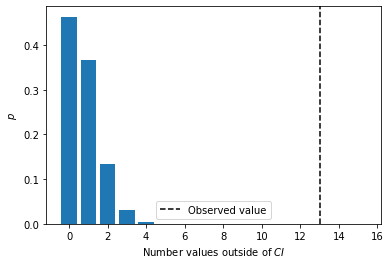

In [ ]:
low_CI = [ci[0] for ci in  VAR_CI]
obs_outside = sum([1 if avg_RMSE[i] < low_CI[i] else 0 for i in range(len(low_CI))])
n = 15
p = 0.05
plt.bar(range(n+1), [stats.binom.pmf(r, n, p) for r in range(n+1) ])
plt.axvline(obs_outside, color = 'black',linestyle = 'dashed',label = 'Observed value')
plt.legend()
plt.xlabel(r'Number values outside of $CI$')
plt.ylabel(r'$p$')
plt.show()



Based on this results we can reject the hypothesis that both $RMSE$ values for the $AR$ and the $VAR$ model stem from the same distribution. All and all, this points at the differences we observed in the $RMSE$ being significant and thus the $VAR$ being significantly worse than the $AR$

### Appendix 

Stuff that may still be relevant but are not part of the main/final workflow

Fitting the model to the entire time series per company 

In [ ]:
lags = [13,16,6,9,4,5,4,8,5,10,7,5,8,6,16]
AR_models = []
res_av = []
norm_test = []
assumptions = pd.DataFrame({'stock': list(df_prices),'res_avg':np.repeat(0,len(list(df_prices))),'res_autocor':np.repeat(0,len(list(df_prices))),
'normality (p-value)':np.repeat(0,len(list(df_prices)))})

for i, comp in enumerate(df_prices.columns):
    p = lags[i]
    data = df_prices[comp]

    ar_model = AutoReg(data, lags=p).fit()

    AR_models.append(ar_model)

    # 2. RES AVG = 0
    res_av.append(np.mean(ar_model.resid))

    # 3. AUTOCORRELATED RESIDUALS MISSING!!
    ar_model.test_serial_correlation()

    # 4. NORMALITY (ONLY OUTPUT THE P-VALUE)
    norm_test.append(jarque_bera(AR_models[0].resid)[1])

assumptions['res_avg'] = res_av
assumptions['normality (p-value)'] = norm_test

df_prices.head()

c:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:2027: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly set lags to silence this warning.
  warnings.warn(


,AAPL,MSFT,BAC,AMZN,TSLA,XOM,JPM,KO,WMT,CVX,JNJ,HD,PG,MRK,PFE
Date,,,,,,,,,,,,,,,
2011-01-04,0.005219,0.003931,0.003524,0.004288,0.001878,0.004695,0.014473,-0.020699,0.003849,-0.003698,0.008437,-0.018125,0.002779,0.008602,0.017534
2011-01-05,0.008180,-0.003204,0.018258,0.013026,0.005999,-0.002670,0.012229,-0.005950,-0.006573,-0.001747,-0.000631,-0.003172,-0.002310,0.005777,0.006671
2011-01-06,-0.000808,0.029286,-0.004138,-0.008324,0.039135,0.006426,-0.004922,-0.007245,-0.008270,-0.008202,-0.001580,-0.004051,-0.001698,0.013676,0.003865
2011-01-07,0.007161,-0.007634,-0.013158,-0.001991,0.012912,0.005453,-0.018885,-0.001745,0.002224,0.005514,-0.009650,-0.001162,-0.002937,0.007825,0.008801
2011-01-10,0.018833,-0.013287,0.010526,-0.004367,0.007436,-0.006086,-0.005500,0.002225,-0.006472,-0.008554,-0.007029,0.000291,-0.002171,-0.004016,-0.004362
